In [1]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
# import yfinance as yf
from yahoo_fin.stock_info import get_data
# import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import KernelPCA
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

ticker ="^990100-USD-STRD" #"^FTSE" #"^RUT" #"^GSPC" #"^VIX" #"^990100-USD-STRD"
n_components = 2

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [2]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker=ticker, start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP(n_components=n_components)
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())
decomposer = KernelPCA(n_components=n_components)
decomposed =decomposer.fit_transform(frame.select('embeddings').to_series().to_list())


In [3]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
frame = frame.with_columns(pl.Series(name = 'decomposed', values = decomposed))

# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

In [4]:
frame = frame.sort('date').set_sorted('date').with_columns(pl.col('close').rolling_std(by='date', window_size = '1w').alias('std'))

In [5]:
frame = frame.drop_nulls()

In [6]:
frame = frame.with_columns(pl.col('close').rolling_mean(window_size = '1mo', by='date').alias('mean'))

In [7]:
frame.with_columns(pl.col('close').qcut([0.10,0.20,0.80,0.90]))

date,label,sentence,embeddings,close,quarter,year,reduced,decomposed,std,mean
date,i64,str,list[f64],cat,i8,i32,list[f32],list[f64],f64,f64
2008-08-11,1,"""New York Senat…","[-0.034912, 0.019608, … 0.00705]","""(0.00677922017…",3,2008,"[11.669406, 7.670897]","[-0.087196, 0.10759]",0.003269,0.008764
2008-08-12,0,"""Gold plunges t…","[-0.044525, 0.028824, … -0.011269]","""(-0.0124947021…",3,2008,"[11.709095, 7.672984]","[-0.061607, 0.118246]",0.009328,-0.000217
2008-08-13,0,"""DreamWorks Ani…","[-0.032074, 0.025146, … 0.015137]","""(-0.0124947021…",3,2008,"[11.672067, 7.661198]","[-0.046698, 0.115567]",0.009879,-0.003928
2008-08-14,1,"""Temecula Valle…","[-0.043121, 0.02681, … 0.010452]","""(-0.0068066192…",3,2008,"[11.587511, 7.57269]","[-0.079004, 0.114393]",0.008967,-0.001921
2008-08-15,1,"""Free Rainwater…","[-0.02565, 0.041412, … -0.005875]","""(-0.0068066192…",3,2008,"[11.801779, 7.610954]","[-0.053156, 0.12775]",0.008564,-0.00216
…,…,…,…,…,…,…,…,…,…,…
2015-12-04,1,"""Sprott Focus T…","[-0.014244, 0.033936, … -0.007206]","""(0.00677922017…",4,2015,"[2.920385, 4.079612]","[0.080402, -0.099636]",0.009651,-0.00093
2015-12-07,0,"""Rentrak Announ…","[0.006672, 0.037231, … 0.026917]","""(-0.0068066192…",4,2015,"[3.35701, 3.562777]","[0.166768, -0.128027]",0.009771,-0.000942
2015-12-08,0,"""ATWOOD OCEANIC…","[-0.003252, 0.035645, … 0.014435]","""(-0.0124947021…",4,2015,"[2.924901, 4.037797]","[0.111097, -0.047489]",0.008396,-0.001388


In [8]:
returns = frame.select('close').to_series()
q10 = returns.quantile(0.20)
q20 = returns.quantile(0.40)
q80 = returns.quantile(0.60)
q90 = returns.quantile(0.80)

In [9]:
frame = (
    frame
    .with_columns(
        pl.when((pl.col('close')>=(q90))).then(1)
        .when((pl.col('close')>=(q80)) & (pl.col('close')<(q90))).then(2)
        .when((pl.col('close')>=(q20)) & (pl.col('close')<(q80))).then(3)
        .when((pl.col('close')>=(q10)) & (pl.col('close')<(q20))).then(4)
        .when((pl.col('close')<(q10))).then(5)
        .alias('quantiles')
    )
)

## Getting lineplots

In [10]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame, model_type: str, intercept: bool = True, start_year: int =2008):
    if model_type == 'ols':
        model = LinearRegression(fit_intercept=intercept)
    elif model_type == 'ridge':
        model = Ridge(fit_intercept=intercept)
    elif model_type == 'lasso':
        model = Lasso(fit_intercept=intercept)
    elif model_type == 'elastic net':
        model = ElasticNet(fit_intercept=intercept)

    df = df.filter(pl.col('date').dt.year().ge(start_year))

    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y[:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    in_sample = reg.predict(X[:ind])
    predicted = np.append(in_sample, out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', y_col, 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = max(out_of_sample) + 0.05, s = "Out of Sample")

    # print("Coefficients: \n", reg.coef_)
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=0,s=f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.01,s=f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.02,s=f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.03,s= f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")

    print(f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    print(f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    print(f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    print(f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")
    print(f"Average of the prediction : {np.mean(out_of_sample)}")
    print(f"Average of the true values : {np.mean(y[ind:])}")
    print(f"Std of the prediction : {np.std(out_of_sample)}")
    print(f"Std of the true values : {np.std(y[ind:])}")

    return

Mean squared error (in sample): 0.00
Coefficient of determination (in sample): 0.00
Mean squared error (out of sample): 0.00
Coefficient of determination (out of sample): -0.00
Average of the prediction : -0.00026194096281602515
Average of the true values : -7.277308110384134e-05
Std of the prediction : 4.735924714034738e-05
Std of the true values : 0.006814888499697596


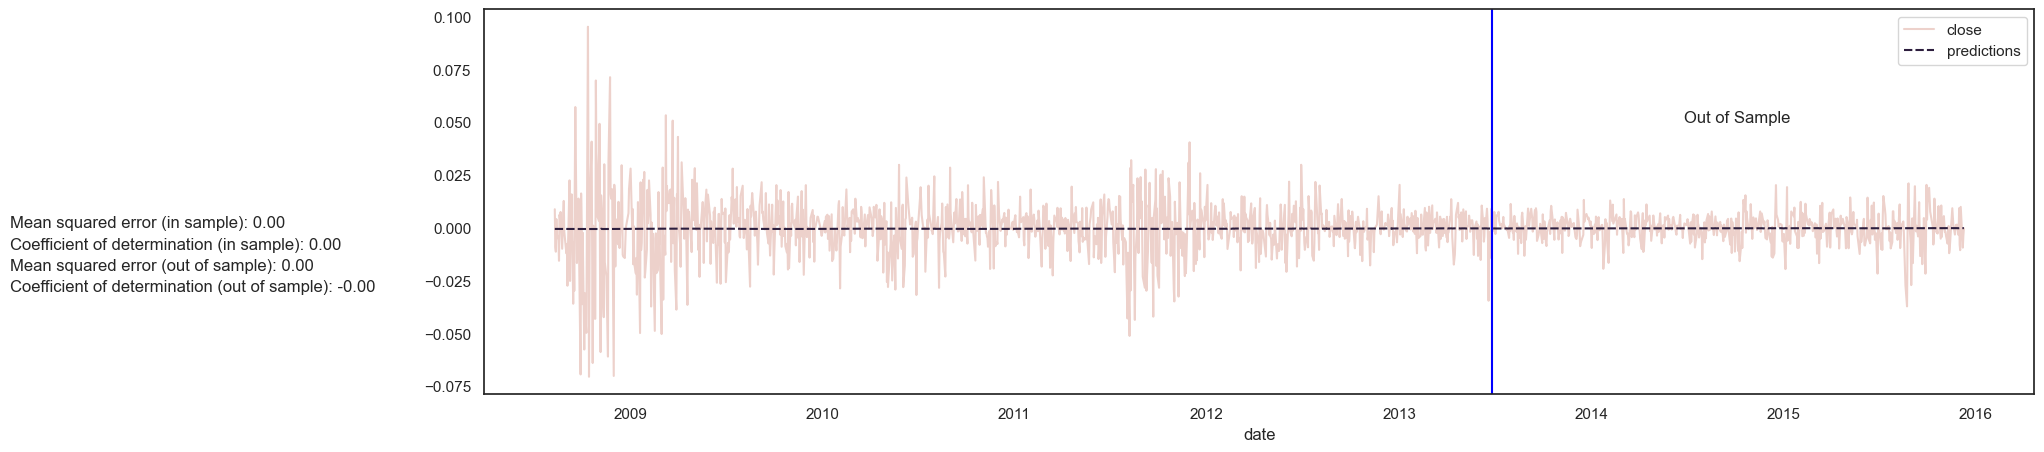

In [11]:
get_linear_regression(x_col='reduced', y_col='close', df=frame, model_type = 'ols', intercept = False, start_year = 2008)

## Getting Logistic Regression

In [ ]:
def get_logistic_regression(df: pl.DataFrame, penalty: str, x_col: str, y_col: str = 'quantiles'):
    model = LogisticRegression(penalty=penalty, multi_class='multinomial')
    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()

    ind = -int(len(X)/3)

    X_test = X[ind:]
    X_train = X[:ind]

    y_test = y[ind:]
    y_train = y[:ind]

    reg = model.fit(X_train, y_train)

    out_of_sample = reg.predict(X_test)
    in_sample = reg.predict(X_train)

    print('Accuracy:', accuracy_score(y_train, in_sample))
    print('Precision:', precision_score(y_train, in_sample, average='weighted'))
    print('Recall:', recall_score(y_train, in_sample, average='weighted'))
    print('F1 score:', f1_score(y_train, in_sample, average='weighted'))
    print('Confusion matrix:\n', confusion_matrix(y_train, in_sample))

    print('Accuracy (Out of Sample):', accuracy_score(y_test, out_of_sample))
    print('Precision (Out of Sample):', precision_score(y_test, out_of_sample, average='weighted'))
    print('Recall (Out of Sample):', recall_score(y_test, out_of_sample, average='weighted'))
    print('F1 score (Out of Sample):', f1_score(y_test, out_of_sample, average='weighted'))
    print('Confusion matrix (Out of Sample):\n', confusion_matrix(y_test, out_of_sample))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    cm = confusion_matrix(y_train, in_sample)
    axs[0].matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[0].text(j, i, cm[i, j], ha='center', va='center')
    axs[0].set_xlabel('Predicted Class')
    axs[0].set_ylabel('True Class')
    axs[0].set_title('In Sample')

    cm = confusion_matrix(y_test, out_of_sample)
    axs[1].matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[1].text(j, i, cm[i, j], ha='center', va='center')
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('True Class')
    axs[1].set_title('Out of Sample')

    plt.tight_layout()
    plt.show()
    return

In [12]:
model = LogisticRegression(penalty=None, multi_class='multinomial')
df = frame 
x_col = "embeddings"
y_col = "quantiles"

In [13]:
X = df.select(pl.col(x_col)).to_series().to_list()
y = df.select(pl.col(y_col)).to_series().to_list()
# y = np.argmax(y, axis=1)

ind = -int(len(X)/3)

X_test = X[ind:]
X_train = X[:ind]

y_test = y[ind:]
y_train = y[:ind]


reg = model.fit(X_train, y_train)

out_of_sample = reg.predict(X_test)
in_sample = reg.predict(X_train)
predicted = np.append(in_sample, out_of_sample)

c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8586387434554974
Precision: 0.8593148900122451
Recall: 0.8586387434554974
F1 score: 0.858598624239
Confusion matrix:
 [[239   6  10   8   9]
 [ 10 179   8  10  11]
 [  5   3 157   7   6]
 [  9   5   8 175  12]
 [ 15   7   1  12 234]]
Accuracy (Out of Sample): 0.2202797202797203
Precision (Out of Sample): 0.2123550719630182
Recall (Out of Sample): 0.2202797202797203
F1 score (Out of Sample): 0.2116198341897894
Confusion matrix (Out of Sample):
 [[11 10 28 17  6]
 [11 15 52 37 11]
 [11 38 53 47 16]
 [ 7 13 58 40 17]
 [ 4 15 32 16  7]]


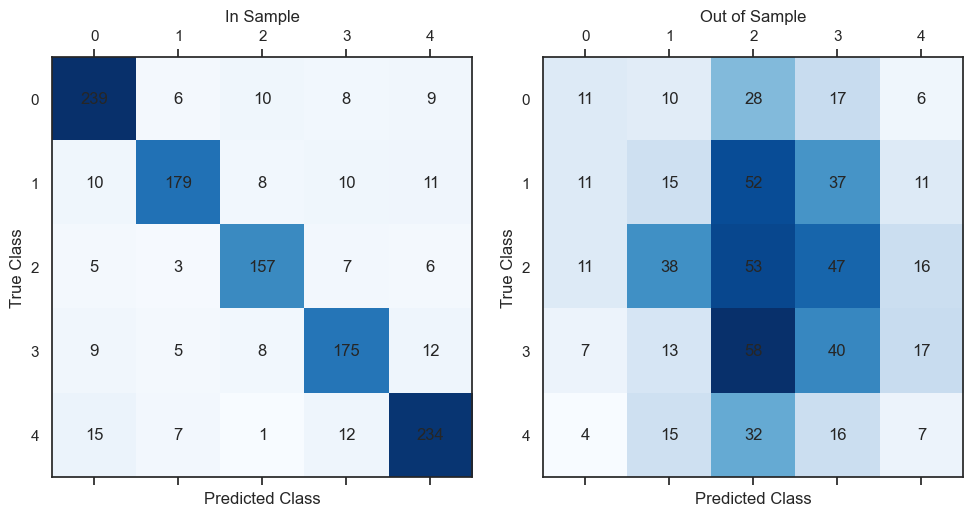

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_train, in_sample))
print('Precision:', precision_score(y_train, in_sample, average='weighted'))
print('Recall:', recall_score(y_train, in_sample, average='weighted'))
print('F1 score:', f1_score(y_train, in_sample, average='weighted'))
print('Confusion matrix:\n', confusion_matrix(y_train, in_sample))

print('Accuracy (Out of Sample):', accuracy_score(y_test, out_of_sample))
print('Precision (Out of Sample):', precision_score(y_test, out_of_sample, average='weighted'))
print('Recall (Out of Sample):', recall_score(y_test, out_of_sample, average='weighted'))
print('F1 score (Out of Sample):', f1_score(y_test, out_of_sample, average='weighted'))
print('Confusion matrix (Out of Sample):\n', confusion_matrix(y_test, out_of_sample))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# counts = df['quantiles'].value_counts()
# axs[0].bar(counts.index.to_numpy(), counts.values / len(df))
# sns.histplot(data=df.to_pandas(), x='quantiles', ax=axs[0], discrete=True, binwidth = 0.1)
# axs[0].set_xlabel('Class')
# axs[0].set_ylabel('Proportion')
# axs[0].set_title('Observations per class')
# axs[0].set_xticklabels(counts.to_pandas().index)

cm = confusion_matrix(y_train, in_sample)
axs[0].matshow(cm, cmap=plt.cm.Blues)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[0].text(j, i, cm[i, j], ha='center', va='center')
axs[0].set_xlabel('Predicted Class')
axs[0].set_ylabel('True Class')
axs[0].set_title('In Sample')
# axs[1].set_xticklabels(['1', '2', '3', '4', '5'])
# axs[1].set_yticklabels(['1', '2', '3', '4', '5'])

cm = confusion_matrix(y_test, out_of_sample)
axs[1].matshow(cm, cmap=plt.cm.Blues)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[1].text(j, i, cm[i, j], ha='center', va='center')
axs[1].set_xlabel('Predicted Class')
axs[1].set_ylabel('True Class')
axs[1].set_title('Out of Sample')
# axs[2].set_xticklabels(['1', '2', '3', '4', '5'])
# axs[2].set_yticklabels(['1', '2', '3', '4', '5'])
# axs[2].set_xticklabels(['10%', '20%', '80%', '90%'])
# axs[2].set_yticklabels(['10%', '20%', '80%', '90%'])

plt.tight_layout()
plt.show()

In [16]:
# from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve
# from sklearn.multiclass import OneVsRestClassifier

# y_pred = reg.predict(X_test)
# logreg = reg

# # Generate and plot confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# # disp = plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues)
# # disp.ax_.set_title('Confusion Matrix')

# # Generate binary classifiers for each class
# ovr = OneVsRestClassifier(logreg)
# y_score = ovr.fit(X_train, y_train).decision_function(X_test)

# # Plot ROC curve for each class
# for i in range(y_score.shape[1]):
#     fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, roc_auc))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()
